# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
current_hour = datetime.datetime.utcnow().hour
are_today_results_partial = current_hour != 23

### Constants

In [3]:
from Modules.ExposureNotification import exposure_notification_io

spain_region_country_code = "ES"
germany_region_country_code = "DE"

default_backend_identifier = spain_region_country_code

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

default_shared_diagnosis_generation_to_upload_days = 1

### Parameters

In [4]:
environment_backend_identifier = os.environ.get("RADARCOVID_REPORT__BACKEND_IDENTIFIER")
if environment_backend_identifier:
    report_backend_identifier = environment_backend_identifier
else:
    report_backend_identifier = default_backend_identifier
report_backend_identifier

'ES'

In [5]:
efgs_supported_countries_backend_identifier = germany_region_country_code
efgs_supported_countries_backend_client = \
    exposure_notification_io.get_backend_client_with_identifier(
        backend_identifier=efgs_supported_countries_backend_identifier)
efgs_source_regions = efgs_supported_countries_backend_client.get_supported_countries()
if report_backend_identifier in efgs_source_regions:
    default_source_regions = "EFGS"
else:
    default_source_regions = report_backend_identifier.split("-")[0].split("@")[0]

environment_source_regions = os.environ.get("RADARCOVID_REPORT__SOURCE_REGIONS")
if environment_source_regions:
    report_source_regions = environment_source_regions
else:
    report_source_regions = default_source_regions

if report_source_regions == "EFGS":
    if report_backend_identifier in efgs_source_regions:
        efgs_source_regions = \
            [report_backend_identifier] + \
            sorted(list(set(efgs_source_regions).difference([report_backend_identifier])))
    report_source_regions = efgs_source_regions
else:
    report_source_regions = report_source_regions.split(",")

report_source_regions

['ES']

In [6]:
environment_download_only_from_report_backend = \
    os.environ.get("RADARCOVID_REPORT__DOWNLOAD_ONLY_FROM_REPORT_BACKEND")
if environment_download_only_from_report_backend:
    report_backend_identifiers = [report_backend_identifier]
else:
    report_backend_identifiers = None

report_backend_identifiers

In [7]:
environment_shared_diagnosis_generation_to_upload_days = \
    os.environ.get("RADARCOVID_REPORT__SHARED_DIAGNOSIS_GENERATION_TO_UPLOAD_DAYS")
if environment_shared_diagnosis_generation_to_upload_days:
    shared_diagnosis_generation_to_upload_days = \
        int(environment_shared_diagnosis_generation_to_upload_days)
else:
    shared_diagnosis_generation_to_upload_days = \
        default_shared_diagnosis_generation_to_upload_days

shared_diagnosis_generation_to_upload_days

1

### COVID-19 Cases

In [8]:
confirmed_df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv")

radar_covid_countries = set(report_source_regions)

confirmed_df = confirmed_df[["dateRep", "cases", "geoId"]]
confirmed_df.rename(
    columns={
        "dateRep":"sample_date",
        "cases": "new_cases",
        "geoId": "country_code",
    },
    inplace=True)
confirmed_df = confirmed_df[confirmed_df.country_code.isin(radar_covid_countries)]
confirmed_df["sample_date"] = pd.to_datetime(confirmed_df.sample_date, dayfirst=True)
confirmed_df = confirmed_df.groupby("sample_date").new_cases.sum().reset_index()
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases
294,2020-10-20,13873
295,2020-10-21,16973
296,2020-10-22,20986
297,2020-10-23,19851
298,2020-10-24,0


In [9]:
confirmed_days = pd.date_range(
    start=confirmed_df.iloc[0].sample_date,
    end=extraction_datetime)
confirmed_days_df = pd.DataFrame(data=confirmed_days, columns=["sample_date"])
confirmed_df = confirmed_days_df.merge(confirmed_df, how="left")
confirmed_df["sample_date"] = confirmed_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases
295,2020-10-21,16973.0
296,2020-10-22,20986.0
297,2020-10-23,19851.0
298,2020-10-24,0.0
299,2020-10-25,NaN


In [10]:
confirmed_df.columns = ["sample_date_string", "new_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df.fillna(method="ffill", inplace=True)
confirmed_df["covid_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.tail()

,sample_date_string,new_cases,covid_cases
295,2020-10-21,16973.0,13891.0
296,2020-10-22,20986.0,14987.0
297,2020-10-23,19851.0,15653.0
298,2020-10-24,0.0,15653.0
299,2020-10-25,0.0,15653.0


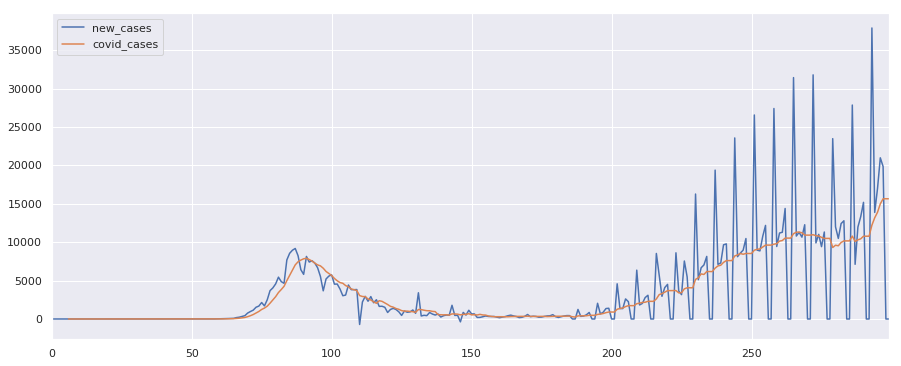

In [11]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [12]:
raw_zip_path_prefix = "Data/TEKs/Raw/"
fail_on_error_backend_identifiers = [report_backend_identifier]
multi_backend_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        backend_identifiers=report_backend_identifiers,
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=fail_on_error_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_backend_exposure_keys_df["region"] = multi_backend_exposure_keys_df["backend_identifier"]
multi_backend_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_backend_exposure_keys_df.head()

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 97, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 25, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/v

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 97, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 25, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/v

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 97, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 25, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/v

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 97, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/ES/inde

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 97, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/IE/inde

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 97, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/DE/inde

,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2020-10-25,2020-10-25,ES,V1,214,1.2.840.10045.4.3.2,89f2fe42-0797-0150-d1a0-f9869b4b7707,2672640,60,0,ES
1,2020-10-25,2020-10-25,ES,V1,214,1.2.840.10045.4.3.2,4de6f529-831e-4002-05cc-6798101f02f9,2672640,60,0,ES
2,2020-10-25,2020-10-25,ES,V1,214,1.2.840.10045.4.3.2,c0ecf301-2b14-736f-6878-22fb561fa15d,2672640,60,0,ES
3,2020-10-25,2020-10-25,ES,V1,214,1.2.840.10045.4.3.2,5e9ceb0d-0ded-f617-5aa0-7bccdece50d0,2672640,59,0,ES
4,2020-10-25,2020-10-25,ES,V1,214,1.2.840.10045.4.3.2,6a67709a-eed9-9be5-db88-c226a5a074db,2672640,59,0,ES


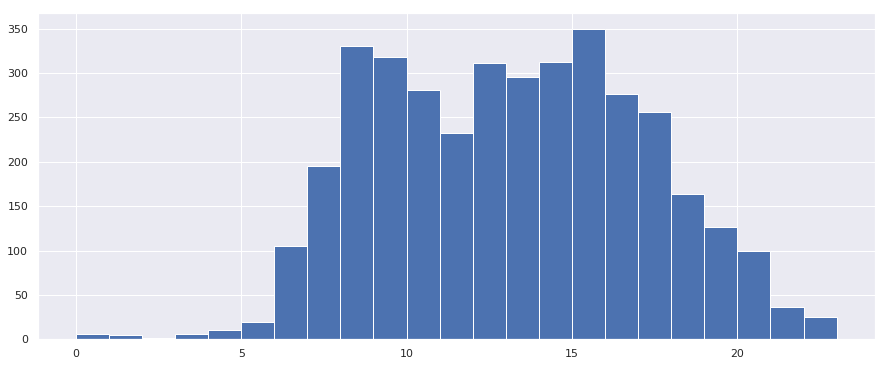

In [13]:
early_teks_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

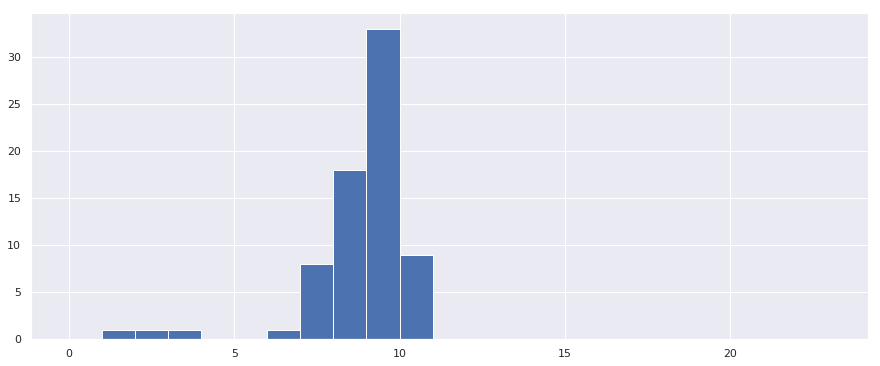

In [14]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [15]:
multi_backend_exposure_keys_df = multi_backend_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_backend_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2020-10-25,ES,89f2fe42-0797-0150-d1a0-f9869b4b7707
1,2020-10-25,ES,4de6f529-831e-4002-05cc-6798101f02f9
2,2020-10-25,ES,c0ecf301-2b14-736f-6878-22fb561fa15d
3,2020-10-25,ES,5e9ceb0d-0ded-f617-5aa0-7bccdece50d0
4,2020-10-25,ES,6a67709a-eed9-9be5-db88-c226a5a074db


In [16]:
active_regions = \
    multi_backend_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['EE', 'BE@TST', 'MT', 'PT', 'ES@PRE', 'ES', 'BE', 'CH', 'IT', 'DE']

In [17]:
multi_backend_summary_df = multi_backend_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_backend_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_backend_summary_df.rename_axis("sample_date", inplace=True)
multi_backend_summary_df = multi_backend_summary_df.fillna(0).astype(int)
multi_backend_summary_df = multi_backend_summary_df.head(backend_generation_days)
multi_backend_summary_df.head()

shared_teks_by_generation_date                                     \
region                                  BE BE@TST    CH    DE  EE   ES ES@PRE   
sample_date                                                                     
2020-10-25                               0      0    46     0   0   25      1   
2020-10-24                               0      0   479     0   2  203      6   
2020-10-23                             376     47  1188  1360   2  312     64   
2020-10-22                             794     52  1816  3152   6  448    130   
2020-10-21                            1191     47  2281  4478  13  523    242   

                             
region         IT   MT   PT  
sample_date                  
2020-10-25      0    0    0  
2020-10-24     33  102   38  
2020-10-23   1402  107   83  
2020-10-22   3079  110  147  
2020-10-21   2869  114  181

In [18]:
multi_backend_without_active_region_exposure_keys_df = \
    multi_backend_exposure_keys_df[multi_backend_exposure_keys_df.region != report_backend_identifier]
multi_backend_without_active_region = \
    multi_backend_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_backend_without_active_region

['EE', 'BE@TST', 'MT', 'PT', 'ES@PRE', 'BE', 'CH', 'IT', 'DE']

In [19]:
exposure_keys_summary_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.region == report_backend_identifier]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2020-10-25,25
2020-10-24,203
2020-10-23,312
2020-10-22,448
2020-10-21,523


### Dump API TEKs

In [20]:
tek_list_df = multi_backend_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-10-12,BE,"[0157eb00-837b-e83c-00ed-094ad1bd57ab, 04a8e07...",2020-10-25,2020-10-25@10
1,2020-10-12,BE@TST,"[01034ab4-cbac-d94d-ff68-e57b003d9091, 0106e7f...",2020-10-25,2020-10-25@10
2,2020-10-12,CH,"[80e62172-d5c7-7552-a52b-4e7fbfc3a986, ba518ef...",2020-10-25,2020-10-25@10
3,2020-10-12,DE,"[0003a6cd-3069-11f0-7221-50079f4e9636, 001c68e...",2020-10-25,2020-10-25@10
4,2020-10-12,EE,"[ece7e2fc-58cd-3d70-1f91-081f8f637fb5, 54d8f6b...",2020-10-25,2020-10-25@10


### Load TEK Dumps

In [21]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    file_paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        file_paths = file_paths[:limit]
    for file_path in file_paths:
        logging.info(f"Loading TEKs from '{file_path}'...")
        iteration_extracted_teks_df = pd.read_json(file_path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [22]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=report_backend_identifier,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
5,ES,2020-10-12,"[ac63d836-be8a-442b-c542-c5d588091579, 442ae33...",2020-10-25,NaN
15,ES,2020-10-13,"[43fb9b19-33a0-809a-873c-2523924e3969, f871744...",2020-10-25,NaN
25,ES,2020-10-14,"[b5536203-fb67-77da-3395-a135ad406a66, bc600ff...",2020-10-25,NaN
35,ES,2020-10-15,"[c8570ea6-535e-6523-1acd-8129bf3eb289, 76694a4...",2020-10-25,NaN
45,ES,2020-10-16,"[1c1a3613-fb95-b462-87fd-7e7db104d880, 366452b...",2020-10-25,NaN


In [23]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-10-25,25
2020-10-24,203
2020-10-23,312
2020-10-22,448
2020-10-21,523


### Daily New TEKs

In [24]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{af214518-3c22-fd44-f885-207eafa69183, c9c909c..."
2020-08-30,"{af214518-3c22-fd44-f885-207eafa69183, c9c909c..."
2020-08-31,"{af214518-3c22-fd44-f885-207eafa69183, c9c909c..."
2020-09-01,"{af214518-3c22-fd44-f885-207eafa69183, c9c909c..."
2020-09-02,"{af214518-3c22-fd44-f885-207eafa69183, c9c909c..."


In [25]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-25-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
10,2020-08-30,2020-08-29,16,1
9,2020-08-30,2020-08-28,5,2
8,2020-08-30,2020-08-27,3,3
7,2020-08-30,2020-08-26,3,4
6,2020-08-30,2020-08-25,2,5


In [26]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
85,2020-10-25,2020-10-20,11,5
75,2020-10-25,2020-10-19,6,6
65,2020-10-25,2020-10-18,3,7
55,2020-10-25,2020-10-17,2,8
45,2020-10-25,2020-10-16,2,9


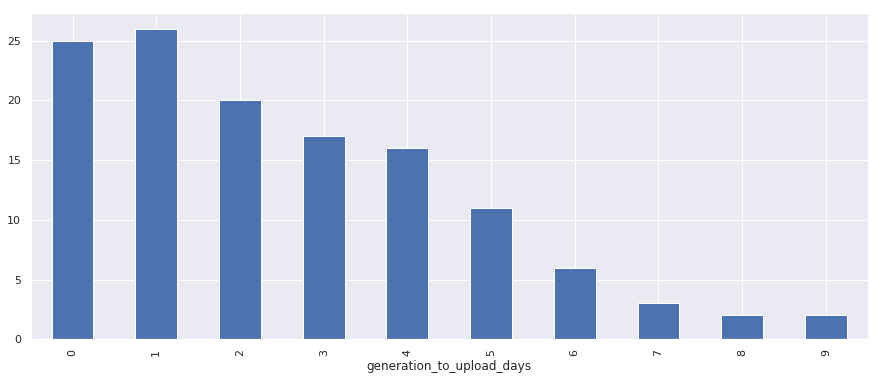

In [27]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [28]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2020-10-25,25,26,20,17,16,11,6,3,2,2,0,0,0,0
2020-10-24,177,125,106,89,69,50,28,19,12,10,6,5,5,2
2020-10-23,167,145,129,106,85,58,29,19,14,9,3,3,1,1
2020-10-22,180,132,114,100,76,51,26,18,10,6,4,4,3,2
2020-10-21,157,153,136,120,97,62,34,28,20,15,9,4,3,3


In [29]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
53,2020-10-21,841.0
54,2020-10-22,726.0
55,2020-10-23,769.0
56,2020-10-24,703.0
57,2020-10-25,128.0


In [30]:
estimated_shared_diagnoses_df = daily_extracted_teks_df.copy()
estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(estimated_shared_diagnoses_df.sample_date) + \
    datetime.timedelta(shared_diagnosis_generation_to_upload_days)
estimated_shared_diagnoses_df["extraction_date"] = pd.to_datetime(estimated_shared_diagnoses_df.extraction_date)
estimated_shared_diagnoses_df["sample_date"] = pd.to_datetime(estimated_shared_diagnoses_df.sample_date)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
5,ES,2020-10-12,"[ac63d836-be8a-442b-c542-c5d588091579, 442ae33...",2020-10-25,NaN,2020-10-13
15,ES,2020-10-13,"[43fb9b19-33a0-809a-873c-2523924e3969, f871744...",2020-10-25,NaN,2020-10-14
25,ES,2020-10-14,"[b5536203-fb67-77da-3395-a135ad406a66, bc600ff...",2020-10-25,NaN,2020-10-15
35,ES,2020-10-15,"[c8570ea6-535e-6523-1acd-8129bf3eb289, 76694a4...",2020-10-25,NaN,2020-10-16
45,ES,2020-10-16,"[1c1a3613-fb95-b462-87fd-7e7db104d880, 366452b...",2020-10-25,NaN,2020-10-17


In [31]:
# Sometimes TEKs from the same day are uploaded, we do not count them as new TEK devices:
same_day_tek_list_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.sample_date == estimated_shared_diagnoses_df.extraction_date].copy()
same_day_tek_list_df = same_day_tek_list_df[["extraction_date", "tek_list"]].rename(
    columns={"tek_list": "same_day_tek_list"})
same_day_tek_list_df.head()

,extraction_date,same_day_tek_list
128,2020-10-25,"[89f2fe42-0797-0150-d1a0-f9869b4b7707, 4de6f52..."
128,2020-10-24,"[98c7e64d-c2ca-6272-3114-84c70734315d, 663f955..."
128,2020-10-23,"[c183bc1b-ab2d-b3e1-593a-25aa1a70be72, decd21d..."
139,2020-10-22,"[ffcfb805-c03e-e043-997b-fd875bc22cf2, 8e0508d..."
90,2020-10-21,"[63d1502a-a158-a5d2-001a-cbb82b9abcf5, ed1bc81..."


In [32]:
shared_teks_uploaded_on_generation_date_df = same_day_tek_list_df.rename(
    columns={
        "extraction_date": "sample_date_string",
        "same_day_tek_list": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date = \
 shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date.apply(len)
shared_teks_uploaded_on_generation_date_df.head()
shared_teks_uploaded_on_generation_date_df["sample_date_string"] = \
    shared_teks_uploaded_on_generation_date_df.sample_date_string.dt.strftime("%Y-%m-%d")
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
128,2020-10-25,25
128,2020-10-24,177
128,2020-10-23,167
139,2020-10-22,180
90,2020-10-21,157


In [33]:
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.new_sample_extraction_date == estimated_shared_diagnoses_df.extraction_date]
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
122,ES,2020-10-24,"[7e49c7ac-4162-fe4b-eca2-bb7561e8f1e0, 138f298...",2020-10-25,NaN,2020-10-25
122,ES,2020-10-23,"[c3d59eb7-01f2-ad63-af9d-1ba1f017f356, 110b8d6...",2020-10-24,NaN,2020-10-24
122,ES,2020-10-22,"[90bdf3aa-9f0b-637e-f6cb-23d10feb6a6b, 950663d...",2020-10-23,NaN,2020-10-23
133,ES,2020-10-21,"[40ae3e69-12c6-0482-2912-ea87d48b1aa3, 1afec6b...",2020-10-22,NaN,2020-10-22
85,ES,2020-10-20,"[0f0e336e-b1c9-a45e-3043-5ed28b80e1b0, e143507...",2020-10-21,NaN,2020-10-21


In [34]:
same_day_tek_list_df["extraction_date"] = \
    same_day_tek_list_df.extraction_date + datetime.timedelta(1)
estimated_shared_diagnoses_df = \
    estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
estimated_shared_diagnoses_df["same_day_tek_list"] = \
    estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date,same_day_tek_list
0,ES,2020-10-24,"[7e49c7ac-4162-fe4b-eca2-bb7561e8f1e0, 138f298...",2020-10-25,NaN,2020-10-25,"[98c7e64d-c2ca-6272-3114-84c70734315d, 663f955..."
1,ES,2020-10-23,"[c3d59eb7-01f2-ad63-af9d-1ba1f017f356, 110b8d6...",2020-10-24,NaN,2020-10-24,"[c183bc1b-ab2d-b3e1-593a-25aa1a70be72, decd21d..."
2,ES,2020-10-22,"[90bdf3aa-9f0b-637e-f6cb-23d10feb6a6b, 950663d...",2020-10-23,NaN,2020-10-23,"[ffcfb805-c03e-e043-997b-fd875bc22cf2, 8e0508d..."
3,ES,2020-10-21,"[40ae3e69-12c6-0482-2912-ea87d48b1aa3, 1afec6b...",2020-10-22,NaN,2020-10-22,"[63d1502a-a158-a5d2-001a-cbb82b9abcf5, ed1bc81..."
4,ES,2020-10-20,"[0f0e336e-b1c9-a45e-3043-5ed28b80e1b0, e143507...",2020-10-21,NaN,2020-10-21,"[97b27565-a475-f559-44f7-2b692ee719c3, a031a2f..."


In [35]:
estimated_shared_diagnoses_df.set_index("extraction_date", inplace=True)
if estimated_shared_diagnoses_df.empty:
    estimated_shared_diagnoses_df["shared_diagnoses"] = 0
else:
    estimated_shared_diagnoses_df["shared_diagnoses"] = estimated_shared_diagnoses_df.apply(
        lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1).copy()
estimated_shared_diagnoses_df.reset_index(inplace=True)
estimated_shared_diagnoses_df.rename(columns={
    "extraction_date": "sample_date_string"}, inplace=True)
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[["sample_date_string", "shared_diagnoses"]]
if not estimated_shared_diagnoses_df.empty:
    estimated_shared_diagnoses_df["sample_date_string"] = \
        estimated_shared_diagnoses_df.sample_date_string.dt.strftime("%Y-%m-%d")
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
0,2020-10-25,26
1,2020-10-24,125
2,2020-10-23,145
3,2020-10-22,132
4,2020-10-21,153


### Hourly New TEKs

In [36]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=report_backend_identifier, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
5,ES,2020-10-12,"[ac63d836-be8a-442b-c542-c5d588091579, 442ae33...",2020-10-25,2020-10-25@10
15,ES,2020-10-13,"[43fb9b19-33a0-809a-873c-2523924e3969, f871744...",2020-10-25,2020-10-25@10
25,ES,2020-10-14,"[b5536203-fb67-77da-3395-a135ad406a66, bc600ff...",2020-10-25,2020-10-25@10
35,ES,2020-10-15,"[c8570ea6-535e-6523-1acd-8129bf3eb289, 76694a4...",2020-10-25,2020-10-25@10
45,ES,2020-10-16,"[1c1a3613-fb95-b462-87fd-7e7db104d880, 366452b...",2020-10-25,2020-10-25@10


In [37]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-10-24@09,0
1,2020-10-24@10,160
2,2020-10-24@11,0
3,2020-10-24@12,74
4,2020-10-24@13,0


In [38]:
hourly_estimated_shared_diagnoses_df = hourly_extracted_teks_df.copy()
hourly_estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.sample_date) + \
    datetime.timedelta(shared_diagnosis_generation_to_upload_days)
hourly_estimated_shared_diagnoses_df["extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.extraction_date)

hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[
    hourly_estimated_shared_diagnoses_df.new_sample_extraction_date ==
    hourly_estimated_shared_diagnoses_df.extraction_date]
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
hourly_estimated_shared_diagnoses_df["same_day_tek_list"] = \
    hourly_estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)

if hourly_estimated_shared_diagnoses_df.empty:
    hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = 0
else:
    hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = \
        hourly_estimated_shared_diagnoses_df.apply(
            lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1)
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.sort_values("extraction_date_with_hour").copy()
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df \
    .groupby("extraction_date").shared_diagnoses.diff() \
    .fillna(0).astype(int)

hourly_estimated_shared_diagnoses_df.set_index("extraction_date_with_hour", inplace=True)
hourly_estimated_shared_diagnoses_df.reset_index(inplace=True)
hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[[
    "extraction_date_with_hour", "shared_diagnoses"]]
hourly_estimated_shared_diagnoses_df.head()

,extraction_date_with_hour,shared_diagnoses
0,2020-10-24@09,0
1,2020-10-24@10,27
2,2020-10-24@11,0
3,2020-10-24@12,12
4,2020-10-24@13,0


In [39]:
hourly_summary_df = hourly_new_tek_count_df.merge(
    hourly_estimated_shared_diagnoses_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date,shared_diagnoses
datetime_utc,,,
2020-10-24 10:00:00,2020-10-24@10,160,27
2020-10-24 11:00:00,2020-10-24@11,0,0
2020-10-24 12:00:00,2020-10-24@12,74,12
2020-10-24 13:00:00,2020-10-24@13,0,0
2020-10-24 14:00:00,2020-10-24@14,98,12


### Data Merge

In [40]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-10-25,25,128.0
1,2020-10-24,203,703.0
2,2020-10-23,312,769.0
3,2020-10-22,448,726.0
4,2020-10-21,523,841.0


In [41]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-10-25,25,128.0,25.0
1,2020-10-24,203,703.0,177.0
2,2020-10-23,312,769.0,167.0
3,2020-10-22,448,726.0,180.0
4,2020-10-21,523,841.0,157.0


In [42]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-10-25,25,128.0,25.0,26.0
1,2020-10-24,203,703.0,177.0,125.0
2,2020-10-23,312,769.0,167.0,145.0
3,2020-10-22,448,726.0,180.0,132.0
4,2020-10-21,523,841.0,157.0,153.0


In [43]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-08-03,8532.0,2610.0,NaN,NaN,NaN,NaN
1,2020-08-04,5760.0,3172.0,NaN,NaN,NaN,NaN
2,2020-08-05,2953.0,3304.0,NaN,NaN,NaN,NaN
3,2020-08-06,4088.0,3489.0,NaN,NaN,NaN,NaN
4,2020-08-07,4507.0,3691.0,NaN,NaN,NaN,NaN


In [44]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,,,,,,
2020-10-25,0.0,15653.0,25.0,128.0,25.0,26.0
2020-10-24,0.0,15653.0,203.0,703.0,177.0,125.0
2020-10-23,19851.0,15653.0,312.0,769.0,167.0,145.0
2020-10-22,20986.0,14987.0,448.0,726.0,180.0,132.0
2020-10-21,16973.0,13891.0,523.0,841.0,157.0,153.0


In [45]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)

result_summary_df.head(daily_plot_days)

,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,,,
2020-10-25,0,15653,25,128,25,26,4.923077,0.001661
2020-10-24,0,15653,203,703,177,125,5.624000,0.007986
2020-10-23,19851,15653,312,769,167,145,5.303448,0.009263
2020-10-22,20986,14987,448,726,180,132,5.500000,0.008808
2020-10-21,16973,13891,523,841,157,153,5.496732,0.011014
2020-10-20,13873,13177,602,772,149,135,5.718519,0.010245
2020-10-19,37889,12212,654,791,142,123,6.430894,0.010072
2020-10-18,0,10778,673,726,146,132,5.500000,0.012247
2020-10-17,0,10778,728,767,174,138,5.557971,0.012804


In [46]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)

with pd.option_context("mode.use_inf_as_na", True):
    weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
    weekly_result_summary_df["teks_per_shared_diagnosis"] = \
        (weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses).fillna(0)
    weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
        (weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases).fillna(0)

weekly_result_summary_df.head()

,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,
2020-10-25,101226,2767,4730,839,5.637664,0.008288
2020-10-24,96351,3415,5328,945,5.638095,0.009808
2020-10-23,91476,3940,5392,958,5.628392,0.010473
2020-10-22,86601,4334,5392,954,5.651992,0.011016
2020-10-21,82050,4613,5337,997,5.353059,0.012151


In [47]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[1]
last_7_days_summary

{'covid_cases': 96351,
 'shared_teks_by_generation_date': 3415,
 'shared_teks_by_upload_date': 5328,
 'shared_diagnoses': 945,
 'teks_per_shared_diagnosis': 5.6380952380952385,
 'shared_diagnoses_per_covid_case': 0.009807889902543825}

## Report Results

In [48]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend Identifier",
    "covid_cases": "COVID-19 Cases in Source Countries (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [49]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [50]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,COVID-19 Cases in Source Countries (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)
Sample Date (UTC),,,,,,,
2020-10-25,15653,25,128,25,26,4.923077,0.001661
2020-10-24,15653,203,703,177,125,5.624000,0.007986
2020-10-23,15653,312,769,167,145,5.303448,0.009263
2020-10-22,14987,448,726,180,132,5.500000,0.008808
2020-10-21,13891,523,841,157,153,5.496732,0.011014
...,...,...,...,...,...,...,...
2020-08-07,3691,0,0,0,0,0.000000,0.000000
2020-08-06,3489,0,0,0,0,0.000000,0.000000
2020-08-05,3304,0,0,0,0,0.000000,0.000000


### Daily Summary Plots

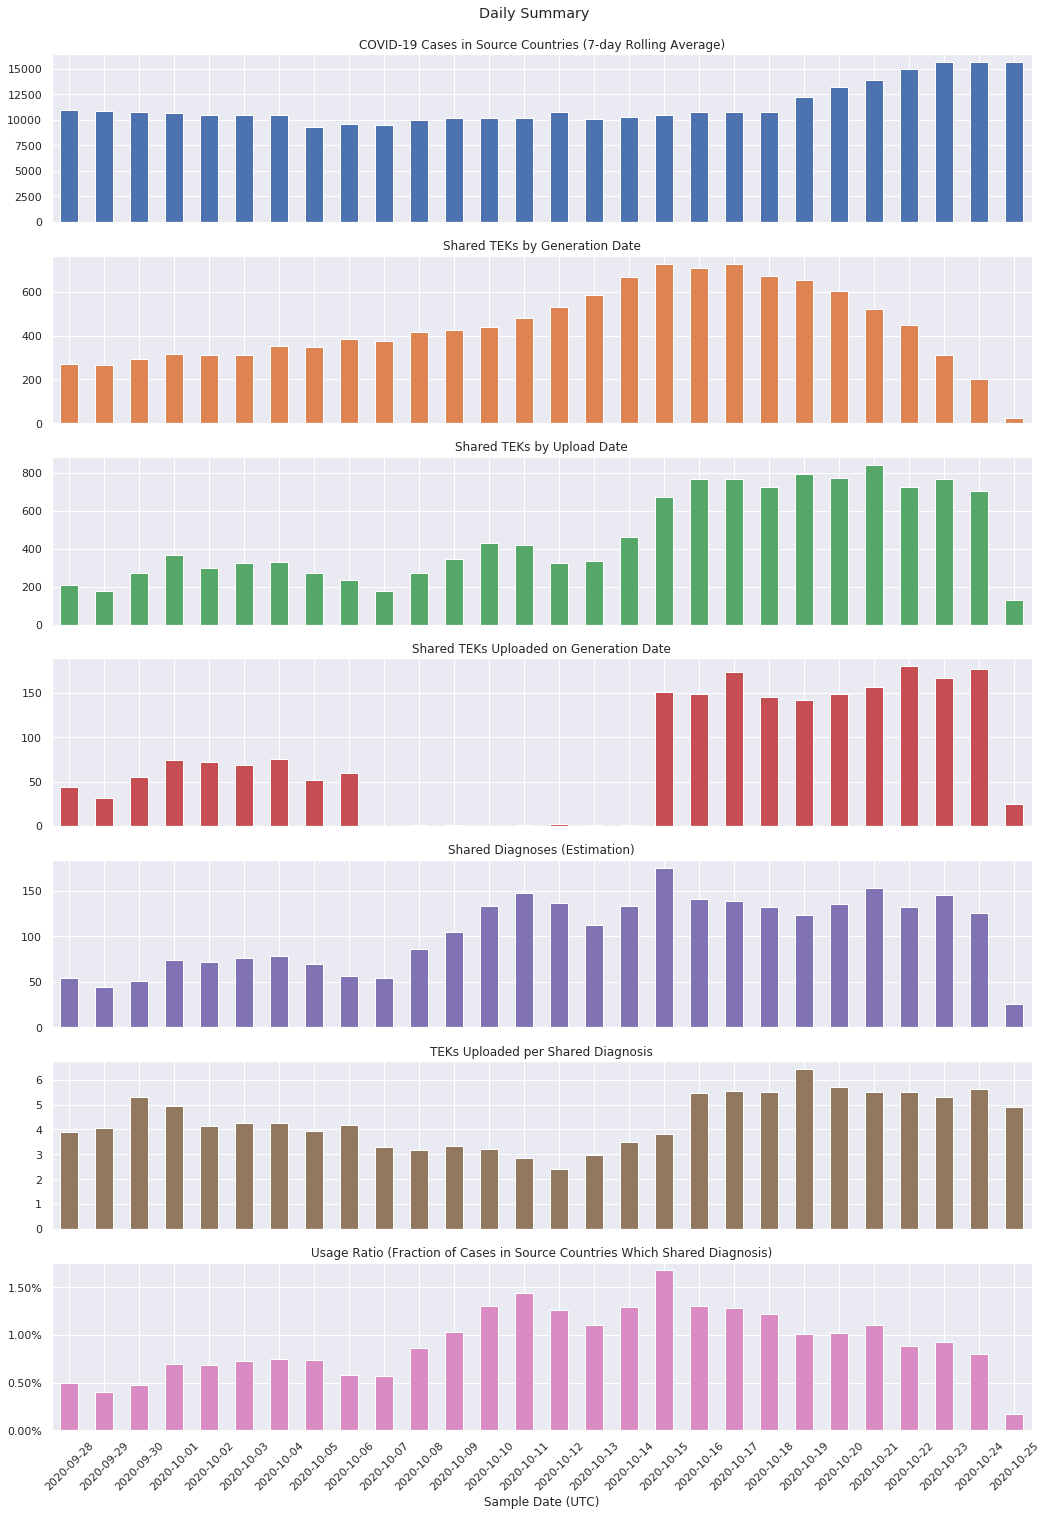

In [51]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Daily Generation to Upload Period Table

In [52]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2020-10-25,25,26,20,17,16,11,6,3,2,2,0,0,0,0
2020-10-24,177,125,106,89,69,50,28,19,12,10,6,5,5,2
2020-10-23,167,145,129,106,85,58,29,19,14,9,3,3,1,1
2020-10-22,180,132,114,100,76,51,26,18,10,6,4,4,3,2
2020-10-21,157,153,136,120,97,62,34,28,20,15,9,4,3,3
2020-10-20,149,135,119,106,79,59,47,25,21,13,8,6,3,2
2020-10-19,142,123,118,105,86,72,45,33,22,17,12,9,4,3
2020-10-18,146,132,114,96,87,54,33,18,12,10,9,7,5,3
2020-10-17,174,138,118,108,84,54,32,19,15,11,7,4,2,1


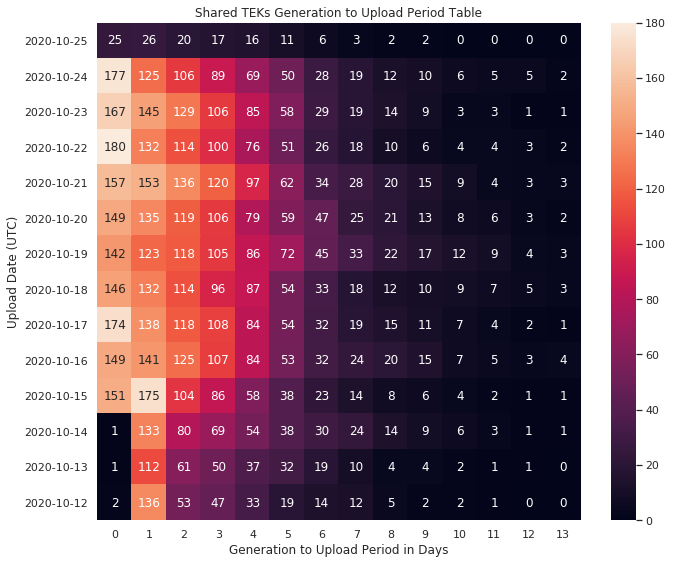

In [53]:
import matplotlib.pyplot as plt

fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(10, 1 + 0.5 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

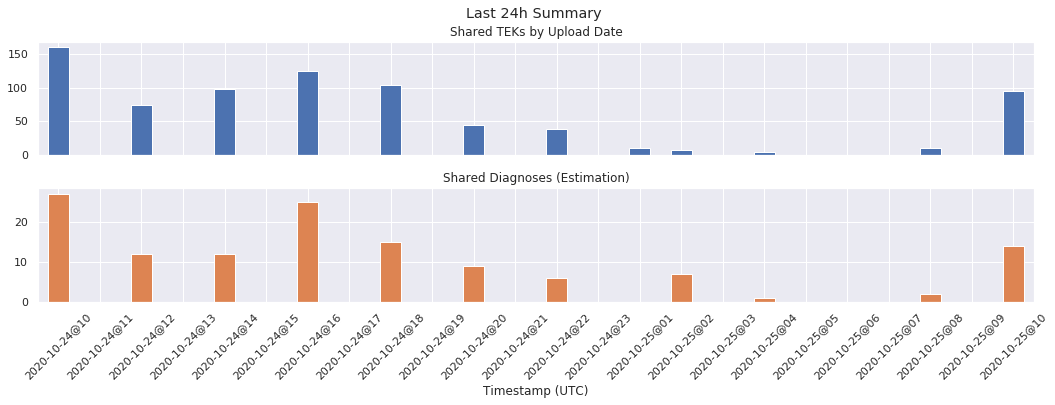

In [54]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [55]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [56]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
}
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_backend_summary_table_html = multi_backend_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)
shared_diagnoses_last_hour = \
    extraction_date_result_hourly_summary_df.shared_diagnoses.sum().astype(int)

display_source_regions = ", ".join(report_source_regions)

display_brief_source_regions_limit = 2
if len(report_source_regions) <= display_brief_source_regions_limit:
    display_brief_source_regions = display_source_regions
else:
    prefix_countries = ", ".join(report_source_regions[:display_brief_source_regions_limit])
    display_brief_source_regions = f"{len(report_source_regions)} ({prefix_countries}…)"

In [57]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_backend_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_backend_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [58]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_backend_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_backend_summary_table_image_path,
    report_resources_path_prefix + "Multi-Backend-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [59]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")

summary_results = dict(
    source_regions=report_source_regions,
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=shared_diagnoses_last_hour,
    ),
    today=dict(
        covid_cases=covid_cases,
        shared_teks_by_generation_date=shared_teks_by_generation_date,
        shared_teks_by_upload_date=shared_teks_by_upload_date,
        shared_diagnoses=shared_diagnoses,
        teks_per_shared_diagnosis=teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=shared_diagnoses_per_covid_case,
    ),
    last_7_days=last_7_days_summary,
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [60]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_backend_summary_table_html=multi_backend_summary_table_html,
    display_source_regions=display_source_regions)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [61]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    if are_today_results_partial:
        today_addendum = " (Partial)"
    else:
        today_addendum = ""

    status = textwrap.dedent(f"""
        #RadarCOVID – {extraction_date_with_hour}

        Countries: {display_brief_source_regions}

        Today{today_addendum}:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f} ({shared_diagnoses_last_hour:+d} last hour)
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Last 7 Days:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)